Prediccion Guanacos

## Generacion del modelo

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from PIL import Image
from io import BytesIO
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import re

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
# las imagenes nuestras tienen Image shape: Width=1920, Height=1080 creo que va a haber que hacer un resizing para poder usar el pre trained

pre_trained_model = InceptionV3(input_shape = (150,150,3), #no estoy seguro de si es el shape correcto, o si puede ser cualquier shape
                                include_top = False, #saca la ultima layer porque es especifica de imagenet
                                weights = 'imagenet')

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

x = Flatten()(pre_trained_model.output) #Flatten output to 1 dimension
x = Dense(1024,activation='relu')(x) #Añade una layer con Relu activation
x = Dropout(0.2)(x) #Añade un dropout rate de 0.2
x = Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input ,x)

model.compile(optimizer = RMSprop(learning_rate = 0.0001),     #learning rate
              loss = 'binary_crossentropy',         #se usa este loss pensando en 2 target classes (podemos para bicho vs no bicho y para guanaco vs no guanaco ponele, sino cambiar)
              metrics = ['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

## Conexion a drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Modelo Guanacos

In [ ]:
# Version Actualizada
train_data = pd.read_pickle('/content/drive/MyDrive/Proyecto Final/Proyecto Final/Python/trainingGuanaco.pkl')
test_data = pd.read_pickle('/content/drive/MyDrive/Proyecto Final/Proyecto Final/Python/testingGuanaco.pkl')

KeyboardInterrupt: ignored

In [ ]:

df = pd.read_pickle('/content/drive/MyDrive/Proyecto Final/Proyecto Final/Python/dataset_entrenamiento.pkl')
df = df[df['Animal']==True]
df['Guanaco'] = np.where(df['Especie'] == 'guanaco', True, False)

In [ ]:
num_classes = len(df['Guanaco'].unique())
num_classes


2

In [ ]:
df.columns

Index(['Ruta', 'Especie', 'Cantidad', 'Animal', 'Imagen', 'Guanaco'], dtype='object')

In [ ]:
df['Imagen'][4]

<tf.Tensor: shape=(150, 150, 3), dtype=float32, numpy=
array([[[250.58    , 254.58    , 253.58    ],
        [247.      , 255.      , 255.      ],
        [247.      , 255.      , 255.      ],
        ...,
        [230.      , 254.      , 254.      ],
        [227.32024 , 255.      , 254.32024 ],
        [224.75644 , 252.75644 , 255.      ]],

       [[245.      , 253.      , 255.      ],
        [242.78001 , 254.45241 , 254.45241 ],
        [244.59401 , 252.59401 , 254.334   ],
        ...,
        [230.18593 , 254.18593 , 254.18593 ],
        [225.52    , 254.26    , 252.52    ],
        [224.      , 254.      , 255.      ]],

       [[243.      , 253.      , 254.      ],
        [238.9     , 254.9     , 253.9     ],
        [237.9     , 252.1     , 252.      ],
        ...,
        [227.      , 255.      , 254.      ],
        [223.1     , 251.1     , 254.33379 ],
        [224.      , 255.      , 255.      ]],

       ...,

       [[ 17.      ,  12.      ,  18.      ],
        [ 17.

guanacos: (1495, 7)
no guanacos: (1604, 7)
total class by class:
 False    1604
True     1495
Name: Guanaco, dtype: int64
Train data shape: (2479,)
Test data shape: (620,)


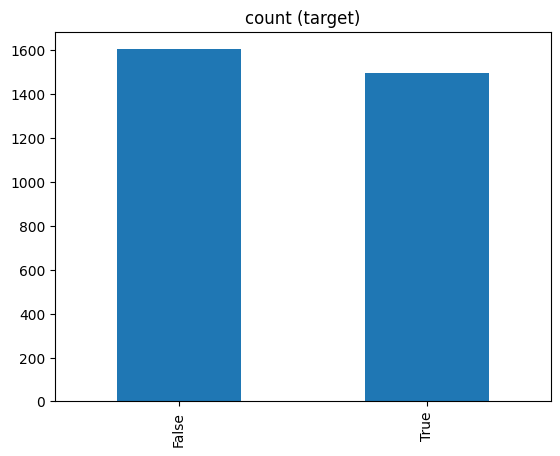

In [ ]:
import os

# Undersampling

guanaco_count, no_guanaco_count = df['Guanaco'].value_counts()

class_guanaco = df[df['Guanaco'] == True]
class_no_guanaco = df[df['Guanaco'] == False]

print('guanacos:', class_guanaco.shape)
print('no guanacos:', class_no_guanaco.shape)

guanaco_under = class_guanaco.sample(no_guanaco_count)

test_under = pd.concat([guanaco_under, class_no_guanaco], axis=0)

print("total class by class:\n",test_under['Guanaco'].value_counts())# plot the count after under-sampeling
test_under['Guanaco'].value_counts().plot(kind='bar', title='count (target)')

X_train, X_test, y_train, y_test = train_test_split(test_under['Imagen'], test_under['Guanaco'], test_size=0.2, random_state=42)

print('Train data shape:', X_train.shape)
print('Test data shape:', X_test.shape)

total class by class:
 False    1604
True     1495
Name: Guanaco, dtype: int64
Train data shape: (2479,)
Test data shape: (620,)


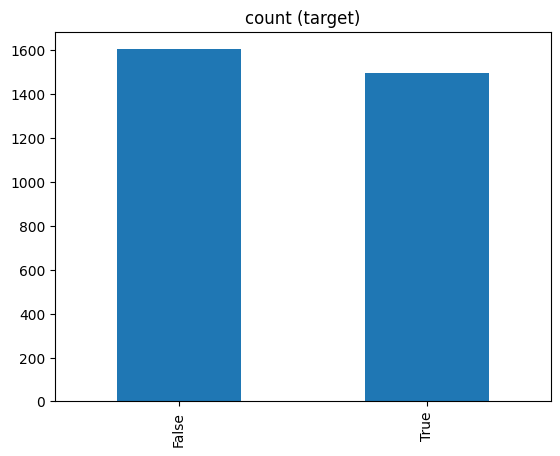

In [ ]:
# Oversampling

guanaco_count, no_guanaco_count = df['Guanaco'].value_counts()

class_guanaco = df[df['Guanaco'] == True]
class_no_guanaco = df[df['Guanaco'] == False]

no_guanaco_over = class_no_guanaco.sample(guanaco_count, replace = True)

test_over = pd.concat([no_guanaco_over, class_guanaco], axis=0)

print("total class by class:\n",test_over['Guanaco'].value_counts())# plot the count after under-sampeling
test_over['Guanaco'].value_counts().plot(kind='bar', title='count (target)')

X_train, X_test, y_train, y_test = train_test_split(test_over['Imagen'], test_over['Guanaco'], test_size=0.2, random_state=42)

print('Train data shape:', X_train.shape)
print('Test data shape:', X_test.shape)


In [ ]:
# Convierte los datos de entrenamiento y etiquetas en tensores de TensorFlow
X_train_tf = tf.convert_to_tensor(np.array([img_to_array(img) for img in X_train]))


## Animal Category

In [ ]:
train_data = pd.read_pickle('/content/drive/MyDrive/Proyecto Final/Proyecto Final/Python/trainingCategoria.pkl')
test_data = pd.read_pickle('/content/drive/MyDrive/Proyecto Final/Proyecto Final/Python/testingCategoria.pkl')

In [ ]:
print(train_data.columns)
print(train_data['Categoria'].value_counts())
herviboro_count, ave_count, carnivoro_count = train_data['Categoria'].value_counts()


class_herv = train_data[train_data['Categoria'] == "Mamifero Herbivoro"]
class_ave = train_data[train_data['Categoria'] == "Ave"]
class_carn = train_data[train_data['Categoria'] == "Mamifero Carnivoro"]

ave_up = class_ave.sample(herviboro_count, replace = True)
carn_up = class_carn.sample(herviboro_count, replace = True)

train_up = pd.concat([ave_up, carn_up , class_herv], axis=0)

print("total class by class:\n",train_up['Categoria'].value_counts())# plot the count after under-sampeling



Index(['Imagen', 'Categoria'], dtype='object')
Mamifero Herbivoro    1283
Ave                    326
Mamifero Carnivoro     136
Name: Categoria, dtype: int64
total class by class:
 Ave                   1283
Mamifero Carnivoro    1283
Mamifero Herbivoro    1283
Name: Categoria, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

y_train = train_up['Categoria']
y_test = test_data['Categoria']


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

num_classes = 3
y_train_encoded = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)




In [ ]:
print(y_train_encoded)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
X_train = train_up['Imagen']
X_test = test_data['Imagen']

X_train_tf = tf.convert_to_tensor(np.array([img_to_array(img) for img in X_train]))
X_test_tf = tf.convert_to_tensor(np.array([img_to_array(img) for img in X_test]))


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping

# Assuming you have 'num_classes' as the number of classes in your dataset
num_classes = 3  # Replace with your actual number of classes

x = Flatten()(pre_trained_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(pre_trained_model.input, predictions)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for multiclass classification
              metrics=['acc', Recall()])

history = model.fit(
    X_train_tf,
    y_train_encoded,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]
)


Epoch 1/20
109/109 [==============================] - 197s 2s/step - loss: 52.8978 - acc: 0.5543 - recall_1: 0.5543 - val_loss: 63.2469 - val_acc: 0.0052 - val_recall_1: 0.0052
Epoch 2/20
109/109 [==============================] - 187s 2s/step - loss: 10.3991 - acc: 0.6328 - recall_1: 0.6325 - val_loss: 2.0555 - val_acc: 0.7896 - val_recall_1: 0.7896
Epoch 3/20
109/109 [==============================] - 186s 2s/step - loss: 2.2961 - acc: 0.6853 - recall_1: 0.6804 - val_loss: 2.2180 - val_acc: 0.4571 - val_recall_1: 0.4156
Epoch 4/20
109/109 [==============================] - 186s 2s/step - loss: 1.1477 - acc: 0.7076 - recall_1: 0.6914 - val_loss: 1.0630 - val_acc: 0.6753 - val_recall_1: 0.6597
Epoch 5/20
109/109 [==============================] - 187s 2s/step - loss: 0.8627 - acc: 0.7589 - recall_1: 0.7442 - val_loss: 1.3696 - val_acc: 0.5429 - val_recall_1: 0.5143
Epoch 6/20
109/109 [==============================] - 186s 2s/step - loss: 0.7697 - acc: 0.7650 - recall_1: 0.7520 - val_l

In [ ]:
test_loss, test_acc = model.evaluate(np.array([img_to_array(img) for img in X_test_tf]), y_test_encoded)
print(f'Accuracy en datos de prueba: {test_acc}')

14/14 [==============================] - 17s 1s/step - loss: 1.1933 - acc: 0.6659 - recall_1: 0.6545


ValueError: ignored

In [ ]:
nombre_modelo = "inception_categories_umpsampled"
model.save('/content/drive/MyDrive/Proyecto Final/Proyecto Final/Python/{}.h5'.format(nombre_modelo))

## Fit Guanacos

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

x = Flatten()(pre_trained_model.output) #Flatten output to 1 dimension
x = Dense(1024,activation='relu')(x) #Añade una layer con Relu activation
x = Dropout(0.2)(x) #Añade un dropout rate de 0.2
predictions = Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input ,predictions)

model.compile(optimizer = RMSprop(learning_rate = 0.0001),     #learning rate (subi de 0.0001 a 0.001 en el undersample)
              loss = 'binary_crossentropy',         #se usa este loss pensando en 2 target classes (podemos para bicho vs no bicho y para guanaco vs no guanaco ponele, sino cambiar)
              metrics = ['acc'])


model.fit(X_train_tf, y_train_tf, epochs=15, batch_size=32, validation_split=0.1)


Epoch 1/15
68/68 [==============================] - 154s 2s/step - loss: 27.2604 - acc: 0.6255 - val_loss: 4.2301 - val_acc: 0.6625
Epoch 2/15
68/68 [==============================] - 145s 2s/step - loss: 2.4851 - acc: 0.6789 - val_loss: 0.9338 - val_acc: 0.7542
Epoch 3/15
68/68 [==============================] - 150s 2s/step - loss: 1.1470 - acc: 0.6989 - val_loss: 1.5817 - val_acc: 0.5167
Epoch 4/15
68/68 [==============================] - 148s 2s/step - loss: 0.9818 - acc: 0.6933 - val_loss: 0.7020 - val_acc: 0.7125
Epoch 5/15
68/68 [==============================] - 149s 2s/step - loss: 0.7610 - acc: 0.7244 - val_loss: 0.6908 - val_acc: 0.7083
Epoch 6/15
68/68 [==============================] - 138s 2s/step - loss: 0.6475 - acc: 0.7509 - val_loss: 0.5707 - val_acc: 0.7708
Epoch 7/15
68/68 [==============================] - 142s 2s/step - loss: 0.6285 - acc: 0.7500 - val_loss: 0.5580 - val_acc: 0.7458
Epoch 8/15
68/68 [==============================] - 144s 2s/step - loss: 0.5639 - 

In [ ]:
test_loss, test_acc = model.evaluate(np.array([img_to_array(img) for img in X_test]), y_test)
print(f'Accuracy en datos de prueba: {test_acc}')

19/19 [==============================] - 31s 2s/step - loss: 0.4906 - acc: 0.7709
Accuracy en datos de prueba: 0.7709029912948608


In [ ]:
nombre_modelo =
model.save('/content/drive/MyDrive/Proyecto Final/Proyecto Final/Python/{}.h5'.format(nombre_modelo))

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

x = Flatten()(pre_trained_model.output) #Flatten output to 1 dimension
x = Dense(1024,activation='relu')(x) #Añade una layer con Relu activation
x = Dropout(0.2)(x) #Añade un dropout rate de 0.2
predictions = Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input ,predictions)

model.compile(optimizer = RMSprop(learning_rate = 0.001),     #learning rate (subi de 0.0001 a 0.001 en el undersample)
              loss = 'binary_crossentropy',         #se usa este loss pensando en 2 target classes (podemos para bicho vs no bicho y para guanaco vs no guanaco ponele, sino cambiar)
              metrics = ['acc'])


model.fit(X_train_tf, y_train_tf, epochs=15, batch_size=32, validation_split=0.1)

Epoch 1/15
68/68 [==============================] - 141s 2s/step - loss: 232.6893 - acc: 0.6445 - val_loss: 136.4494 - val_acc: 0.4708
Epoch 2/15
68/68 [==============================] - 143s 2s/step - loss: 16.2190 - acc: 0.6640 - val_loss: 1.0534 - val_acc: 0.5875
Epoch 3/15
68/68 [==============================] - 142s 2s/step - loss: 3.7246 - acc: 0.6310 - val_loss: 0.7232 - val_acc: 0.5625
Epoch 4/15
12/68 [====>.........................] - ETA: 1:47 - loss: 2.4007 - acc: 0.6224

KeyboardInterrupt: ignored

## Test modelo vgg


In [5]:
model_vgg = tf.keras.models.load_model('/content/drive/MyDrive/Proyecto Final/Proyecto Final/Python/modelo_guanaco.h5')

In [6]:
test_data = pd.read_pickle('/content/drive/MyDrive/Proyecto Final/Proyecto Final/Python/testingGuanaco.pkl')

In [8]:
test_data.columns

Index(['Imagen', 'Guanaco'], dtype='object')

In [9]:
X_test = test_data['Imagen']
y_test = test_data['Guanaco']

In [25]:
y_test.value_counts()

True     299
False    138
Name: Guanaco, dtype: int64

In [15]:
X_test_tf = tf.convert_to_tensor(np.array([img_to_array(img) for img in X_test]))

In [29]:
y_proba = model_vgg.predict(X_test_tf)
y_pred = (y_proba >= 0.975).astype(int)

14/14 [==============================] - 125s 9s/step


In [31]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score,auc, average_precision_score
# Count the number of 1s and 0s in 'y_pred'
count_1s = np.sum(y_pred == 1)
count_0s = np.sum(y_pred == 0)

print(f'Number of 1s in y_pred: {count_1s}')
print(f'Number of 0s in y_pred: {count_0s}')
# Calculamos Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculamos Recall
recall = recall_score(y_test, y_pred, pos_label=1, average='binary')
print(f"Recall: {recall}")

# Calculamos Precision
precision = precision_score(y_test, y_pred, pos_label=1, average='binary')
print(f"Precision: {precision}")

# Calculamos Specificity
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity}")

Number of 1s in y_pred: 39
Number of 0s in y_pred: 398
Accuracy: 0.40503432494279173
Recall: 0.13043478260869565
Precision: 1.0
Specificity: 1.0
